<a href="https://colab.research.google.com/github/gkanfer/SpatialOmicsToolkit/blob/main/notebooks/spatial_data_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysal
!pip install geopandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Initialize the random number generator
RANDOM_SEED = 8925347
rng = np.random.default_rng(RANDOM_SEED)

# Parameters for clusters
num_clusters = 4
min_obs = 3
max_obs = 4

# Parameters for multivariate normal distribution
a0 = 3.5
b1 = 1.5
b2 = 2.5
b3 = 2.5
sigma_a0 = 1.0
sigma_b1 = 0.7
sigma_b2 = 0.3
sigma_b3 = 1.2
rhow_0_1 = -0.8
rhow_0_2 = 0.6
rhow_1_3 = 0.1
rhow_2_3 = 0.9

def makemvn(mean0, mean1, sigma0, sigma1, rho, size):
    mu = [mean0, mean1]
    Rho = np.array([[1, rho], [rho, 1]])
    sigmas = [sigma0, sigma1]
    Sigma = np.diag(sigmas) @ Rho @ np.diag(sigmas)
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=size)

# Create random coordinates for clusters
clusters = []
labels = np.arange(num_clusters).tolist()
rng.shuffle(labels)
label = []

# Generate points for each cluster with associations
cluster_points = []
for i in range(num_clusters):
    num_points = rng.integers(min_obs, max_obs + 1)
    cluster_center = (rng.uniform(0, 100), rng.uniform(0, 100))
    points = rng.normal(loc=cluster_center, scale=5, size=(num_points, 2))
    cluster_points.append(points)
    clusters.append(points)
    label.extend([labels[i]] * num_points)

# Flatten the list of clusters to get all points
all_points = np.vstack(clusters)

# Generate values with associations between clusters
values = np.zeros(all_points.shape[0])

# Generate associated values for each cluster
num_points_cluster_0 = len(clusters[0])
num_points_cluster_1 = len(clusters[1])
num_points_cluster_2 = len(clusters[2])
num_points_cluster_3 = len(clusters[3])

# Cluster 0 and 1 association
cluster_0_1_values = makemvn(a0, b1, sigma_a0, sigma_b1, rhow_0_1, num_points_cluster_0 + num_points_cluster_1)
values[:num_points_cluster_0] = cluster_0_1_values[:num_points_cluster_0, 0]
values[num_points_cluster_0:num_points_cluster_0 + num_points_cluster_1] = cluster_0_1_values[num_points_cluster_0:, 1]

# Cluster 0 and 2 association
cluster_0_2_values = makemvn(a0, b2, sigma_a0, sigma_b2, rhow_0_2, num_points_cluster_2)
values[num_points_cluster_0 + num_points_cluster_1:num_points_cluster_0 + num_points_cluster_1 + num_points_cluster_2] = cluster_0_2_values[:, 1]

# Cluster 1 and 3 association
cluster_1_3_values = makemvn(b1, b3, sigma_b1, sigma_b3, rhow_1_3, num_points_cluster_3)
values[num_points_cluster_0 + num_points_cluster_1 + num_points_cluster_2:] = cluster_1_3_values[:, 1]

# Create a GeoDataFrame
df = gpd.GeoDataFrame({'value': values, 'label': label, 'geometry': [Point(xy) for xy in all_points]})

# Plot the data with cluster labels
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
df.plot(column='label', cmap='viridis', ax=ax, legend=True, categorical=True)
plt.title('Spatial Data with Cluster Labels')
plt.show()




In [ ]:
df

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define artificial data and connections
nodes = [0, 1, 2, 3]
edges = [
    (0, 1), (0, 2),
    (1, 0), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 3),
    (3, 1), (3, 2)
]

# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(nodes)

# Add edges
G.add_edges_from(edges)

# Draw the graph with a smaller figure size
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=15)
plt.show()


# Step 1: Calculate the Pairwise Distance Matrix

Compute the Euclidean distance between each pair of points.

In [ ]:
# Coordinates of the points
coords = np.array([point.coords[0] for point in df.geometry])

# Calculate the pairwise distance matrix
dist_matrix = np.sqrt(((coords[:, np.newaxis] - coords[np.newaxis, :]) ** 2).sum(axis=2))
np.ceil(dist_matrix)

# Step 2: Find the k-nearest Neighbors for Each Point

For each point, find the indices of the k-nearest neighbors.

In [ ]:
k = 4  # Number of nearest neighbors

# Get indices of the k-nearest neighbors for each point
neighbors = np.argsort(dist_matrix, axis=1)[:, 1:k+1]  # Exclude the point itself (hence [1:k+1])


# Step 3: Create the Weights Matrix

Create a binary weights matrix where each entry (i, j) is 1 if j is a neighbor of i.

In [ ]:
# Initialize the weights matrix with zeros
weights_matrix = np.zeros(dist_matrix.shape)

# Set the weights to 1 for the k-nearest neighbors
for i in range(weights_matrix.shape[0]):
    weights_matrix[i, neighbors[i]] = 1
weights_matrix

# Step 4: Normalize the Weights Matrix

Normalize the weights matrix so that the sum of the weights for each point equals 1.

In [ ]:
# Normalize the weights matrix
row_sums = weights_matrix.sum(axis=1)
weights_matrix = weights_matrix / row_sums[:, np.newaxis]
weights_matrix

# Step 5: Calculate Moran's I

Now that we have the weights matrix, we can calculate Moran's I to understand the spatial autocorrelation of the values.



Step 5: Calculate Moran's I

Now that we have the weights matrix, we can calculate Moran's I to understand the spatial autocorrelation of the values.

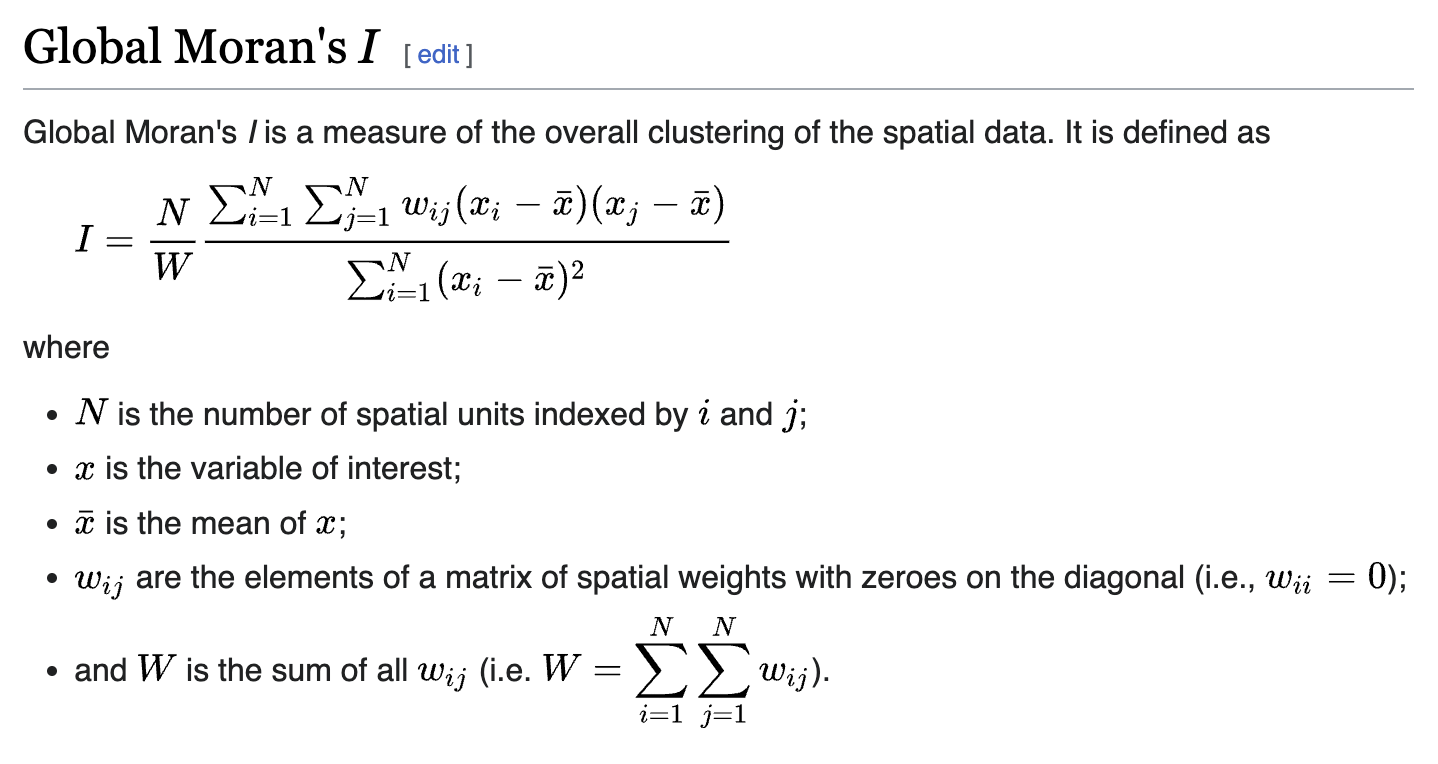

In [ ]:
# Number of points
n = len(values)

# Mean of the values
mean_value = np.mean(values)

# Deviation from the mean
deviation = values - mean_value

# Calculate Moran's I numerator
numerator = np.sum(weights_matrix * np.outer(deviation, deviation))

# Calculate Moran's I denominator
denominator = np.sum(deviation ** 2)

# Calculate Moran's I
moran_i = (n / weights_matrix.sum()) * (numerator / denominator)

# Randomly permute values to calculate p-value
num_permutations = 999
perm_moran_i = []
for _ in range(num_permutations):
    permuted_values = rng.permutation(values)
    perm_deviation = permuted_values - mean_value
    perm_numerator = np.sum(weights_matrix * np.outer(perm_deviation, perm_deviation))
    perm_moran_i.append((n / weights_matrix.sum()) * (perm_numerator / denominator))

perm_moran_i = np.array(perm_moran_i)
p_value = (np.sum(perm_moran_i >= moran_i) + 1) / (num_permutations + 1)

# Print Moran's I value and p-value
print(f"Moran's I: {moran_i}")
print(f"P-value: {p_value}")

# Plot Moran's I scatter plot with labels
fig, ax = plt.subplots(figsize=(4, 3))
scatter = ax.scatter(deviation, np.dot(weights_matrix, deviation),s = 2, edgecolor='k', facecolor='none')

# Annotate each point with its label
for i, txt in enumerate(df['label']):
    ax.annotate(txt, (deviation[i], np.dot(weights_matrix, deviation)[i]))

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title("Moran's I Scatter Plot with Labels")
plt.xlabel('Deviation')
plt.ylabel('Spatial Lag of Deviation')

In [ ]:
weights_matrix_values